# Batch Reactor Example
## Ignition delay computation

In this example we will illustrate how to setup and use a constant volume batch reactor. This reactor will then be used to compute the ignition delay of a gas at any temperature and pressure

The reactor (system) is simply an insulated box.

In [1]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np

import cantera as ct
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.3.0a3


### Define the gas
In this example we will choose n-heptane as the gas. For a representative kinetic model, we use the 160 species [mechanism](https://combustion.llnl.gov/archived-mechanisms/alkanes/heptane-reduced-mechanism) by [Seier et al. 2000, Proc. Comb. Inst](http://dx.doi.org/10.1016/S0082-0784&#40;00&#41;80610-4). 

In [2]:
gas = ct.Solution('data/seiser.cti')



**** WARNING ****
For species c7h15o-1, discontinuity in cp/R detected at Tmid = 1391
	Value computed using low-temperature polynomial:  53.0168
	Value computed using high-temperature polynomial: 52.748


**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767


### Define reactor conditions : temperature, pressure, fuel, stoichiometry

In [3]:
# Define the reactor temperature and pressure
reactorTemperature = 1000 #Kelvin
reactorPressure = 101325.0 #Pascals

gas.TP = reactorTemperature, reactorPressure

# Define the fuel, oxidizer and set the stoichiometry
gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})

# Create a batch reactor object and add it to a reactor network
# In this example, the batch reactor will be the only reactor
# in the network
r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
reactorNetwork = ct.ReactorNet([r])

# now initialize an empty data frame into which we store values
# for this list all the species and turn them into column names
nSpecies = gas.n_species
stateVariables = nSpecies + 3

stateVariableNames = []
for i in range(stateVariables):
    stateVariableNames.append(r.component_name(i))


timeHistory = pd.DataFrame(columns=['time'] + stateVariableNames)

### Define useful functions

In [4]:
def updateStateDataFrame(df, stateArray):
    """
    This function will be used to store all the state variable parameters
    as the reactor evolves over time. At every time-step we call on this 
    function to update the dataFrame
    """
    return df.append(pd.DataFrame([stateArray], columns=df.columns), ignore_index=True)

def ignitionDelay(df, species):
    """
    This function computes the ignition delay from the occurence of the 
    peak 'OH' value.
    """
    return df[species].argmax(), df.iloc[df[species].argmax()]['time']

In [5]:
timeStep=1e-4
simulationEndTime = 0.05
    
times = np.arange(0, simulationEndTime, timeStep)

for t in times:    
    reactorNetwork.advance(t)
    timeHistory = updateStateDataFrame(timeHistory, np.append(t, reactorNetwork.get_state()))

index, tau = ignitionDelay(timeHistory, 'oh')
print('Computed Ignition Delay: {:.3e} seconds'.format(tau))

# If you want to save all the data - molefractions, temperature, pressure, etc
# uncomment the next line 
# timeHistory.to_csv("time_history.csv")

Computed Ignition Delay: 3.250e-02 seconds


## Plot the result

### Import modules and set plotting defaults

In [6]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True

plt.style.use('ggplot')
plt.style.use('seaborn-pastel')

### Figure illustrating the definition of ignition delay

<IPython.core.display.Javascript object>


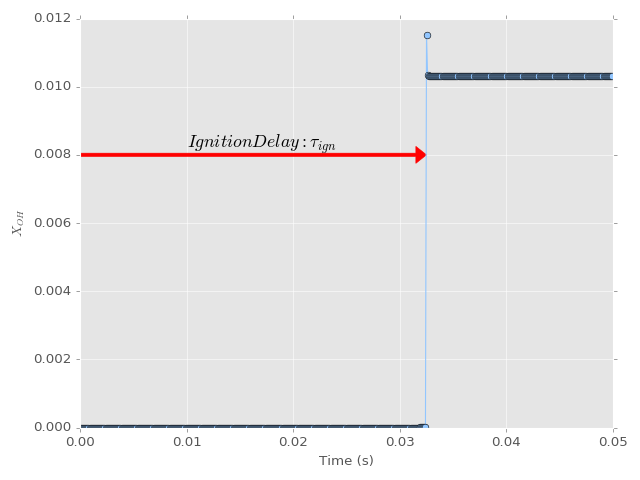

In [7]:
plt.plot(timeHistory['time'], timeHistory['oh'],'-o')
plt.xlabel('Time (s)')
plt.ylabel('$X_{OH}$')
plt.arrow(0, 0.008, tau, 0, width=0.0001, head_width=0.0005, 
          head_length=0.001, length_includes_head=True, color='r', shape='full')
plt.annotate(r'$Ignition Delay: \tau_{ign}$', xy=(0,0), xytext=(0.01, 0.0082), fontsize=16);

## Illustration : NTC behavior
A common benchmark for a reaction mechanism is its ability to reproduce the **N**egative **T**emperature **C**oefficient behavior. Intuitively, as the temperature of an explosive mixture increases, it should ignite faster. But, under certain conditions, we observe the opposite. This is referred to as NTC behavior. Reproducing experimentally observed NTC behavior is thus an important test for any mechanism. We will do this now by computing and visualizing the ignition delay for a wide range of temperatures

### Define the temperatures for which we will run the simulations

In [8]:
# Make a list of all the temperatures we would like to run simulations at
T = [1800, 1600, 1400, 1200, 1000, 950, 925, 900, 850, 825, 800, 
     750, 700, 675, 650, 625, 612.25, 550, 500]

timeSteps = np.ones(len(T))*1e-3

# Make time step adjustments for the highest and lowest temperatures
timeSteps[:5] = [1e-7, 1e-7, 1e-6, 1e-5, 1e-4]
timeSteps[-2] = 1e-2
timeSteps[-1] = 1e-1

# Now create a dataFrame out of these
ignitionDelays = pd.DataFrame(data={'T':T})
ignitionDelays['ignDelay'] = np.nan

Now, what we will do is simply run the code above the plots for each temperature.

In [9]:
for i, temperature in enumerate(T):

    # Setup the gas and reactor
    reactorTemperature = temperature
    reactorPressure = 101325.0 
    gas.TP = reactorTemperature, reactorPressure
    gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})
    r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
    reactorNetwork = ct.ReactorNet([r])

    # Create and empty data frame
    timeHistory = pd.DataFrame(columns=timeHistory.columns)
    
    timeStep = timeSteps[i]
    simulationEndTime = timeStep*1000
    
    times = np.arange(0, simulationEndTime, timeStep)
    for t in times:    
        reactorNetwork.advance(t)
        timeHistory = updateStateDataFrame(timeHistory, np.append(t, reactorNetwork.get_state()))

    index, tau = ignitionDelay(timeHistory, 'oh')
    print('Computed Ignition Delay: {:.3e} seconds for T={}K'.format(tau, temperature))
    
    ignitionDelays.set_value(index=i, col='ignDelay', value=tau)

Computed Ignition Delay: 1.800e-05 seconds for T=1800K
Computed Ignition Delay: 3.520e-05 seconds for T=1600K
Computed Ignition Delay: 1.610e-04 seconds for T=1400K
Computed Ignition Delay: 1.630e-03 seconds for T=1200K
Computed Ignition Delay: 3.250e-02 seconds for T=1000K
Computed Ignition Delay: 8.000e-02 seconds for T=950K
Computed Ignition Delay: 1.260e-01 seconds for T=925K
Computed Ignition Delay: 2.010e-01 seconds for T=900K
Computed Ignition Delay: 4.270e-01 seconds for T=850K
Computed Ignition Delay: 4.730e-01 seconds for T=825K
Computed Ignition Delay: 3.800e-01 seconds for T=800K
Computed Ignition Delay: 1.550e-01 seconds for T=750K
Computed Ignition Delay: 6.600e-02 seconds for T=700K
Computed Ignition Delay: 5.800e-02 seconds for T=675K
Computed Ignition Delay: 7.900e-02 seconds for T=650K
Computed Ignition Delay: 1.540e-01 seconds for T=625K
Computed Ignition Delay: 2.350e-01 seconds for T=612.25K
Computed Ignition Delay: 3.820e+00 seconds for T=550K
Computed Ignition De

### Figure: ignition delay ($\tau$) vs. the inverse of temperature ($\frac{1000}{T}$). 

<IPython.core.display.Javascript object>


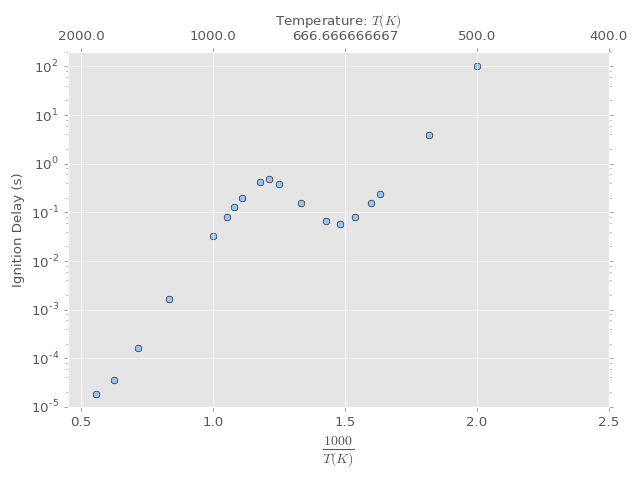

In [13]:
fig = plt.figure()
plt.semilogy(1000/ignitionDelays['T'], ignitionDelays['ignDelay'],'o')

plt.ylim([1e-5, 200])
plt.xlim([0.45, 2.5])

plt.ylabel('Ignition Delay (s)')
plt.xlabel(r'$\frac{1000}{T (K)}$', fontsize=18);

# Add a second axis on top to plot the temperature for better readability
ax = fig.add_subplot(111)
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

topAxisTicks = np.array([0.5, 1.0, 1.5, 2.0, 2.5])
ax2.set_xticks(topAxisTicks)
ax2.set_xticklabels(1000.0/topAxisTicks)
ax2.set_xlabel(r'Temperature: $T(K)$');